# Silhouette

In [1]:
import torch
from torchvision.models import resnet18
from ignite.utils import manual_seed

from analyze import *

manual_seed(123)

## Prepare testee samples

sample batch


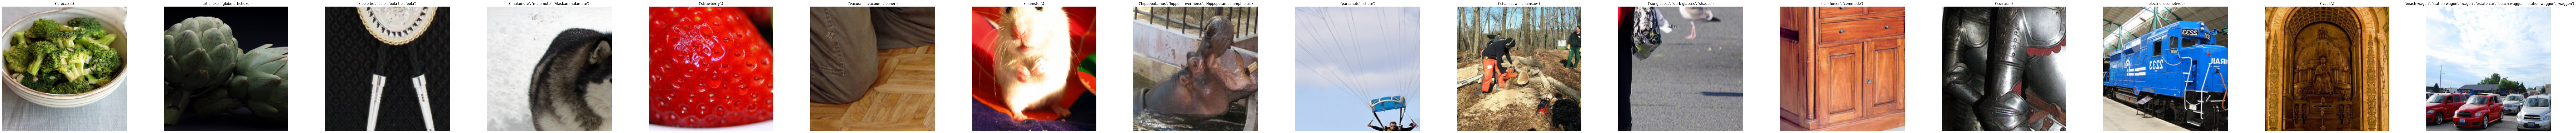

feature map before layer1: torch.Size([16, 64, 112, 112])
feature map between layer1 and layer2: torch.Size([16, 64, 56, 56])


In [2]:
%store -r sample

print(f'sample batch')
visualize_images(sample['batch']['images'],
                 sample['batch']['tags'],
                 sample['batch']['used_normalization'],
                 sample['batch']['classes'])

model = resnet18(pretrained=True)

def prepare_testee_samples(model, batch):
    testee_samples = {}
    
    def extract_feature_map(location):
        def hook(m, i, o):
            testee_samples[location] = o.detach()
        return hook
    
    handle1 = model.relu.register_forward_hook(extract_feature_map('before_layer1'))
    handle2 = model.layer1.register_forward_hook(extract_feature_map('between_layer1_and_layer2'))
    
    model(batch)
    
    handle1.remove()
    handle2.remove()
    
    return testee_samples
    
feature_maps = prepare_testee_samples(model, sample['batch']['images'])

print(f'feature map before layer1: {feature_maps["before_layer1"].size()}')
print(f'feature map between layer1 and layer2: {feature_maps["between_layer1_and_layer2"].size()}')

## Components

### AttentionMapExtractor

In [3]:
from architectures.Silhouette.components_Silhouette import AttentionMapExtractor

def test_AttentionMapExtractor():
    print(f'**AttentionMapExtractor test**')
    print()
    
    layer = AttentionMapExtractor(64, 1000)
    (y, a) = layer(feature_maps['before_layer1'])
    print(f'predicted by AttentionMapExtractor:\n {y.argmax(dim=1)}')
    print(f'ground-truth:\n {sample["batch"]["tags"]}')
    print()
    
    print(f'extracted attention map: {a.size()}')
    print()
    
    return a
    
attention_map = test_AttentionMapExtractor()

**AttentionMapExtractor test**

predicted by AttentionMapExtractor:
 tensor([815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815,
        815, 815])
ground-truth:
 tensor([937, 944, 451, 249, 949, 882, 333, 344, 701, 491, 837, 493, 524, 547,
        884, 436])

extracted attention map: torch.Size([16, 1000, 55, 55])



### compress_attention_map

**compress_attention_map test**

method: max


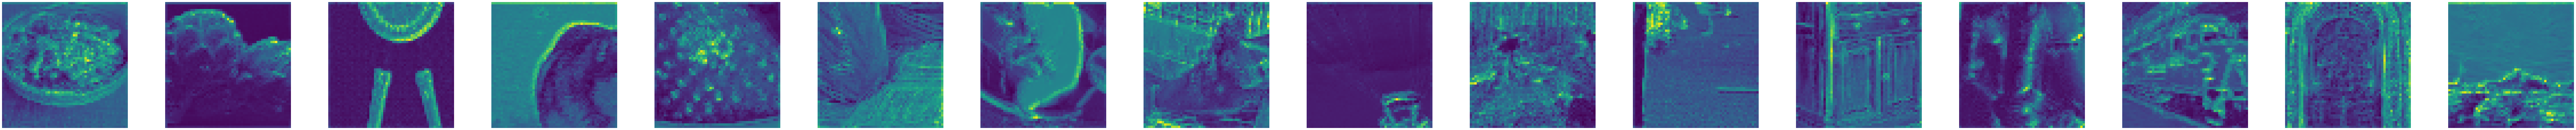

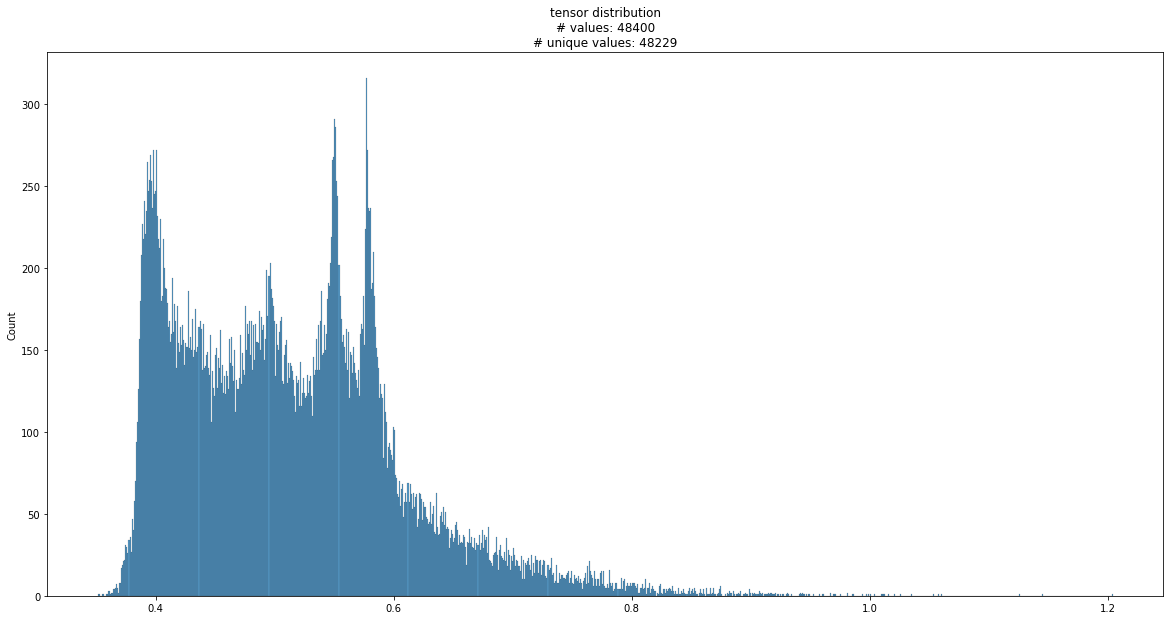

method: avg


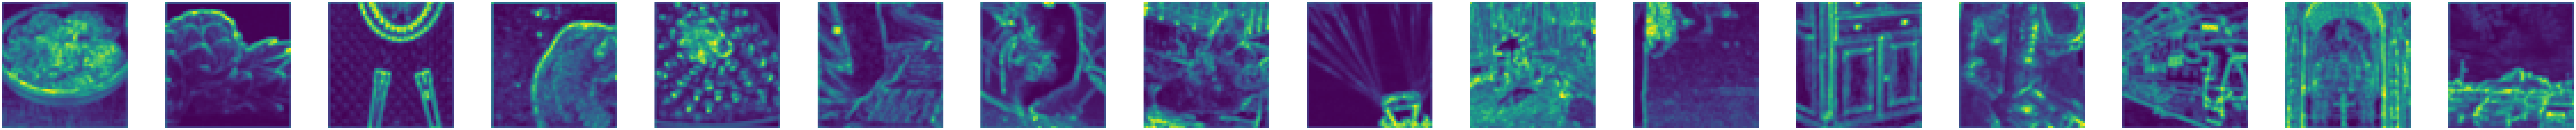

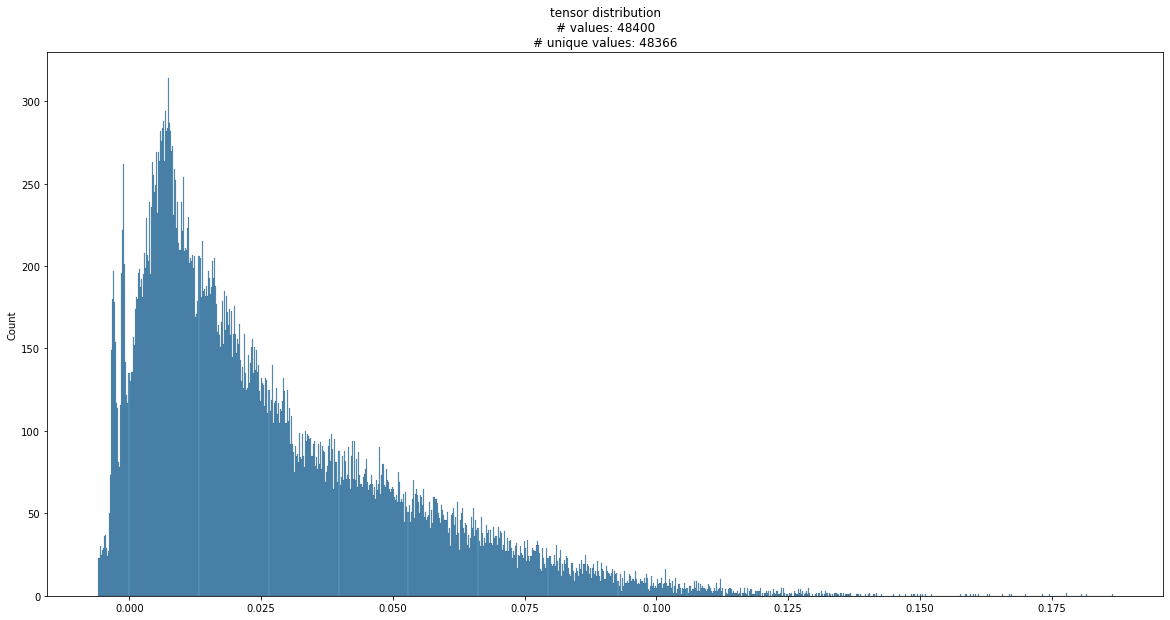

method: top5_activation


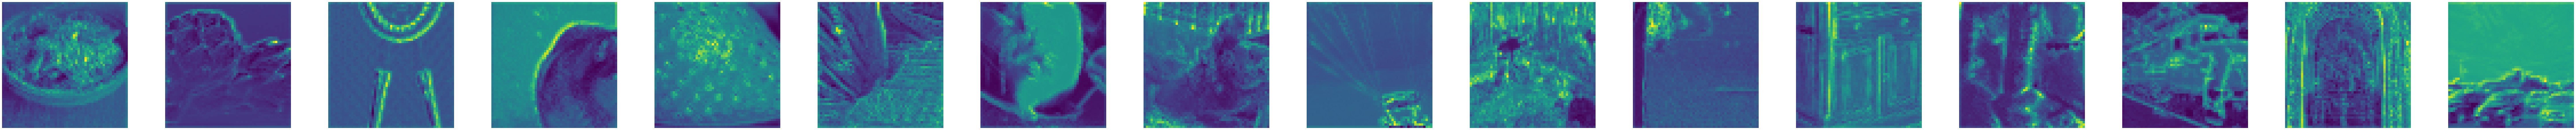

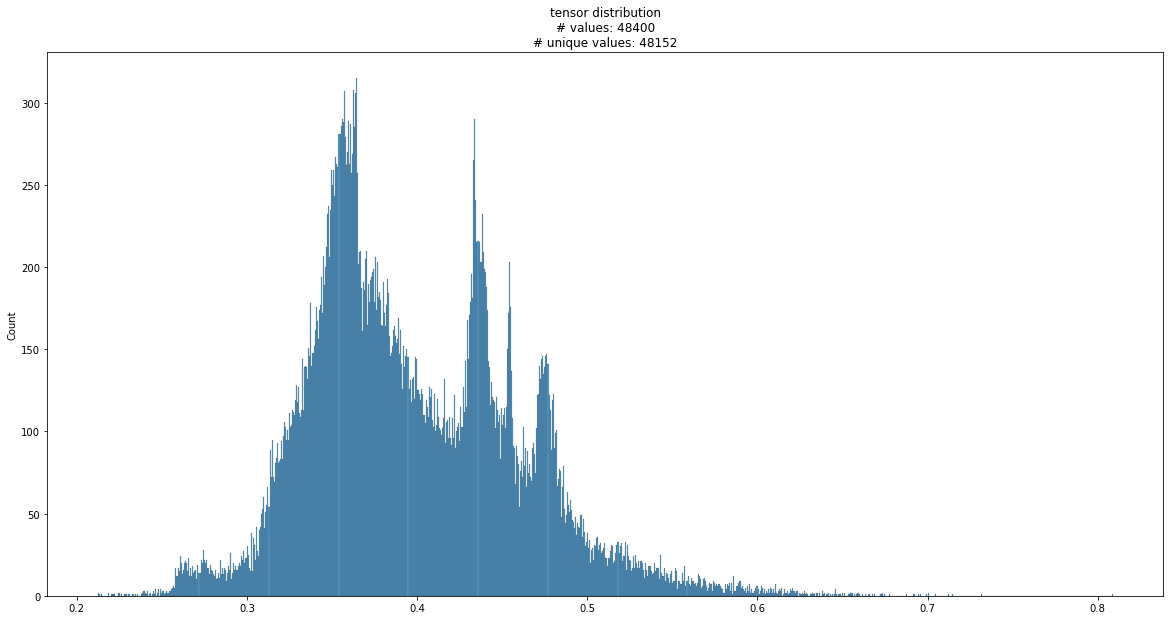

method: top5_deviation_of_activation


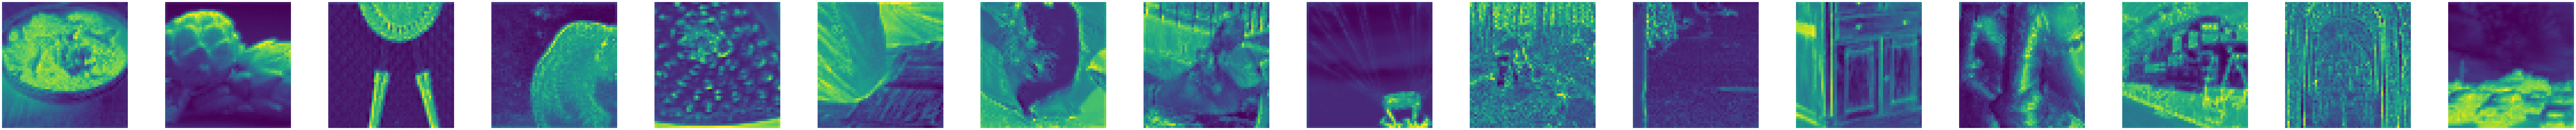

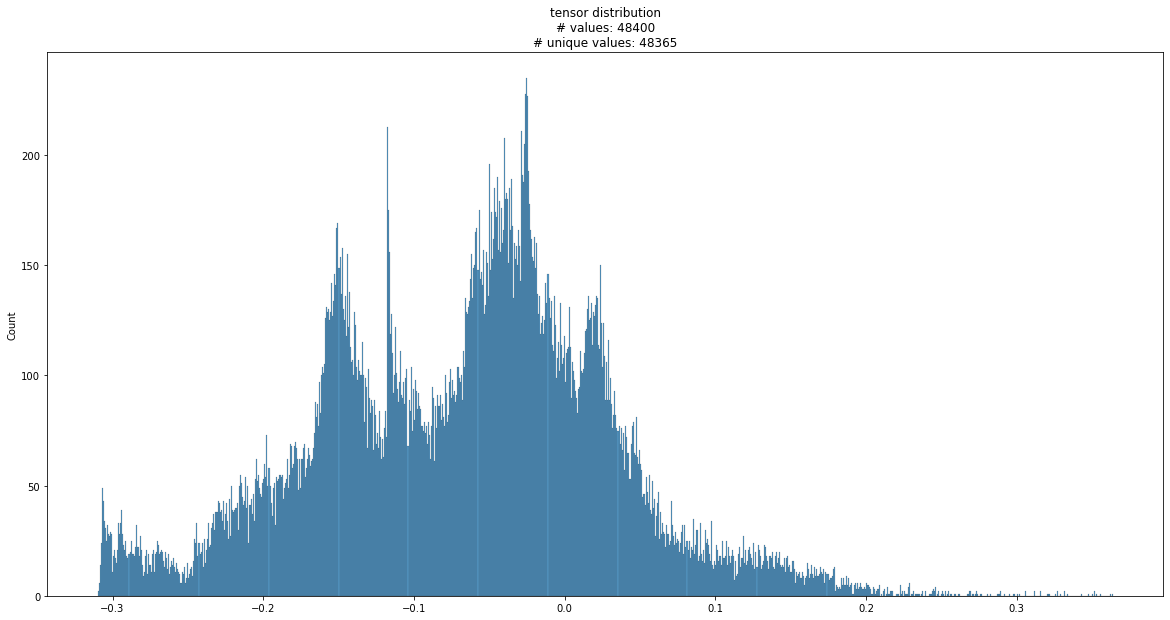

method: random


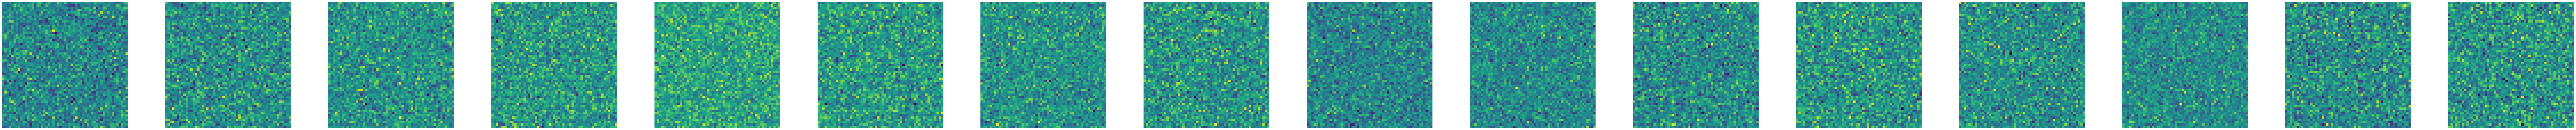

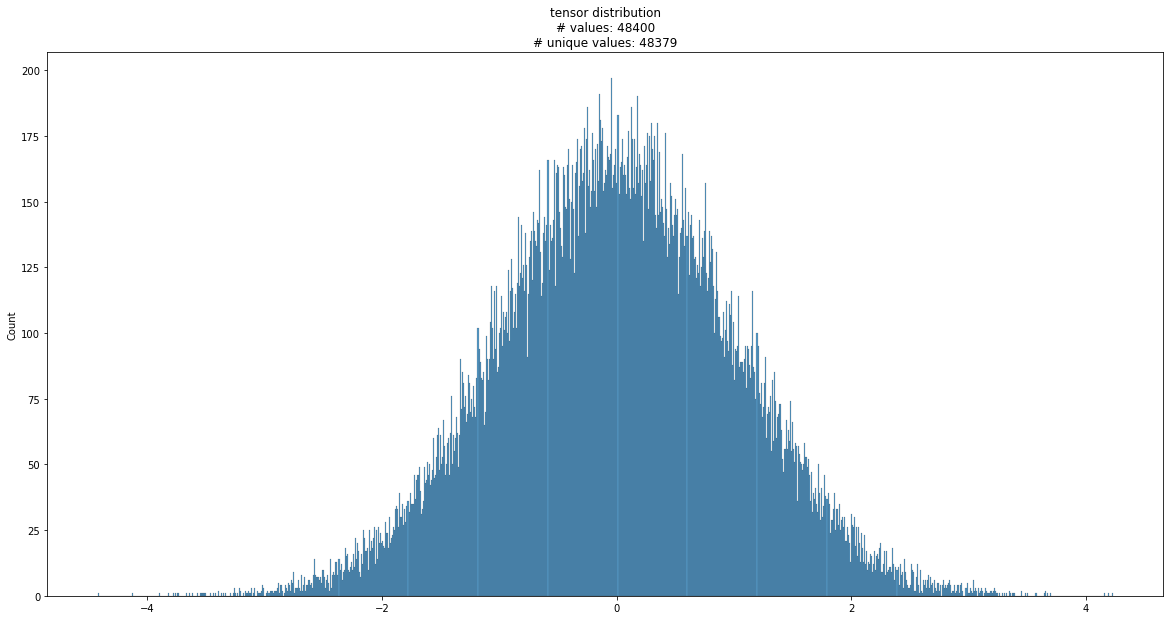

In [4]:
from architectures.Silhouette.components_Silhouette import compress_attention_map

def test_compress_attention_map(attention_map):
    print(f'**compress_attention_map test**')
    print()
    
    print(f'method: max')
    cam_max = compress_attention_map(attention_map, 'max')
    visualize_tensor(cam_max)
    visualize_tensor_distribution(cam_max)
    
    print(f'method: avg')
    cam_avg = compress_attention_map(attention_map, 'avg')
    visualize_tensor(cam_avg)
    visualize_tensor_distribution(cam_avg)
    
    print(f'method: top5_activation')
    cam_top5_act = compress_attention_map(attention_map, 'topk_activation', k=5)
    visualize_tensor(cam_top5_act)
    visualize_tensor_distribution(cam_top5_act)
    
    print(f'method: top5_deviation_of_activation')
    cam_top5_devact = compress_attention_map(attention_map, 'topk_deviation_of_activation', k=5)
    visualize_tensor(cam_top5_devact)
    visualize_tensor_distribution(cam_top5_devact)
    
    print(f'method: random')
    cam_random = compress_attention_map(attention_map, 'random')
    visualize_tensor(cam_random)
    visualize_tensor_distribution(cam_random)
    
test_compress_attention_map(attention_map)

### AuxiliaryNet

**AuxiliaryNet test**
kept Silhouette(compressed attention map)


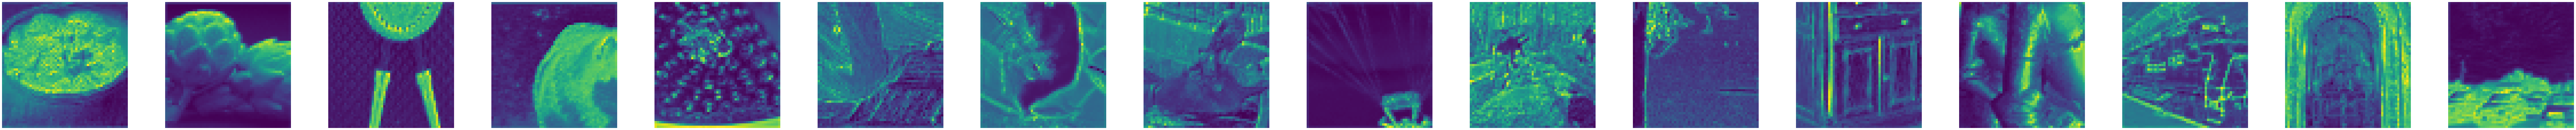

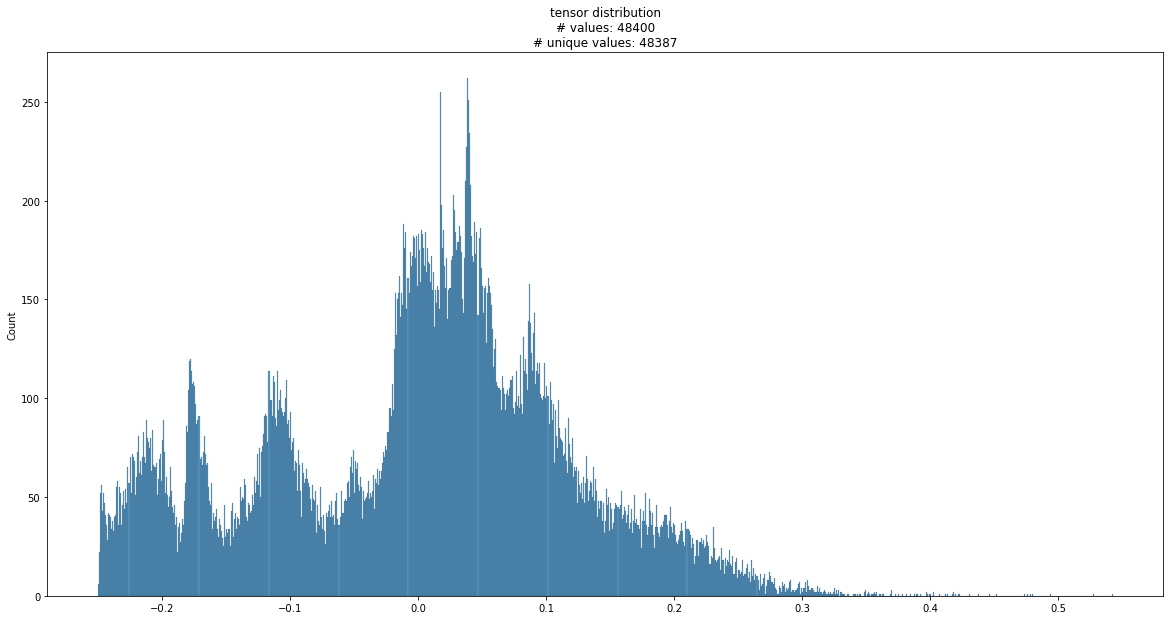

In [5]:
from architectures.Silhouette.components_Silhouette import AuxiliaryNet

def test_AuxiliaryNet():
    print(f'**AuxiliaryNet test**')
    layer = AuxiliaryNet(extractor_config={'in_channels': 64, 'out_channels': 1000},
                         compress_config={'method': 'topk_deviation_of_activation', 'k': 5})
    assert layer.silhouette is None
    layer(feature_maps['before_layer1'])
    assert layer.silhouette is not None
    
    print(f'kept Silhouette(compressed attention map)')
    visualize_tensor(layer.silhouette)
    visualize_tensor_distribution(layer.silhouette)
    
    return layer
    
auxnet = test_AuxiliaryNet()

### encode_policy

In [6]:
from architectures.Silhouette.components_Silhouette import encode_policy

def test_encode_policy():
    print(f'**encode_policy test**')
    policy_list = ['2bit 50%, 3bit 50%',
                   '2bit 50%, 3bit 30%, 4bit 20%',
                   '4bit 50%, 3bit 30%, 2bit 20%']
    for policy in policy_list:
        nbits, quantiles = encode_policy(policy)
        print(f'\tpolicy: {policy}, nbits: {nbits}, quantiles: {quantiles}')
        
test_encode_policy()

**encode_policy test**
	policy: 2bit 50%, 3bit 50%, nbits: [2, 3], quantiles: tensor([0.0000, 0.5000])
	policy: 2bit 50%, 3bit 30%, 4bit 20%, nbits: [2, 3, 4], quantiles: tensor([0.0000, 0.5000, 0.8000])
	policy: 4bit 50%, 3bit 30%, 2bit 20%, nbits: [4, 3, 2], quantiles: tensor([0.0000, 0.5000, 0.8000])


### sectionize_silhouette

**sectionize_silhouette test**

masks generated based on silhouette based on sectioning_policy: 2bit 50%, 3bit 30%, 4bit 20%


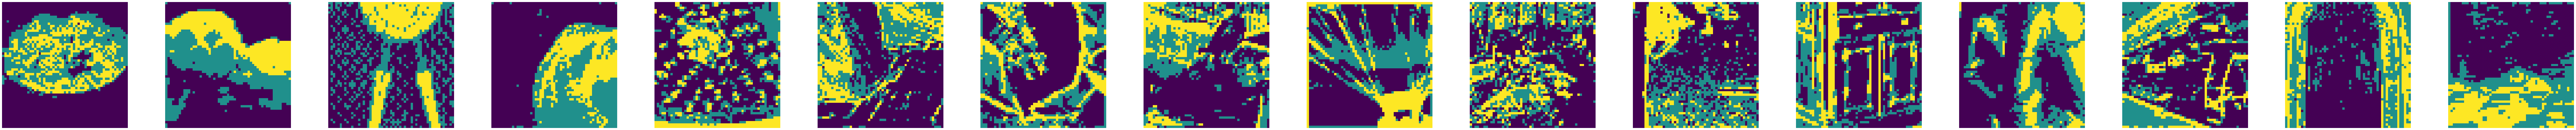

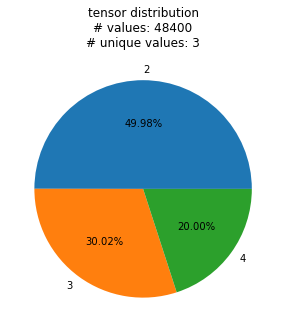

In [7]:
from architectures.Silhouette.components_Silhouette import sectionize_silhouette

def test_sectionize_silhouette(aux_net):
    print(f'**sectionize_silhouette test**')
    print()
    policy = '2bit 50%, 3bit 30%, 4bit 20%'
    nbits, quantiles = encode_policy(policy)
    masks = sectionize_silhouette(aux_net.silhouette, nbits, quantiles)
    
    print(f'masks generated based on silhouette based on sectioning_policy: {policy}')
    visualize_tensor(integrate_mask(masks))
    visualize_tensor_distribution(masks, is_mask=True)
    print()
    
test_sectionize_silhouette(auxnet)

### SilhouetteConv2d

**SilhouetteConv2d test**
simiulate layer1.0.conv1: policy: 2bit 50%, 3bit 30%, 4bit 20%, in_channels: 64, out_channels: 128, options: weight_scaling(X), interpolate before sectioning(X)
mask generated:


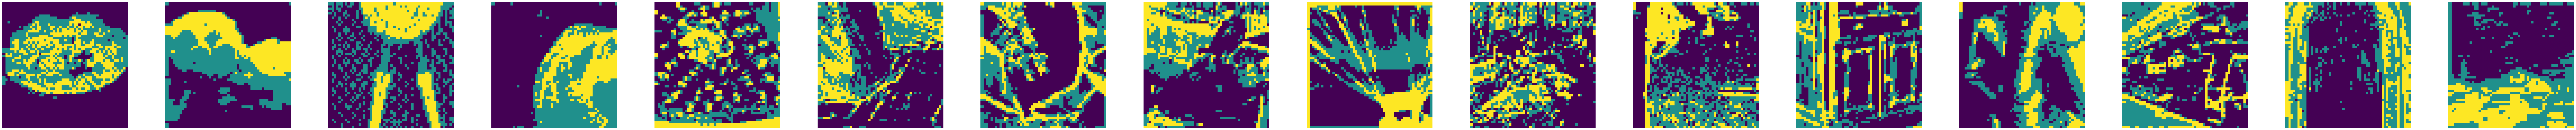

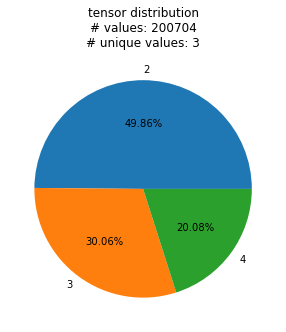


quantized weights in conv layer:
    bit-width: 2


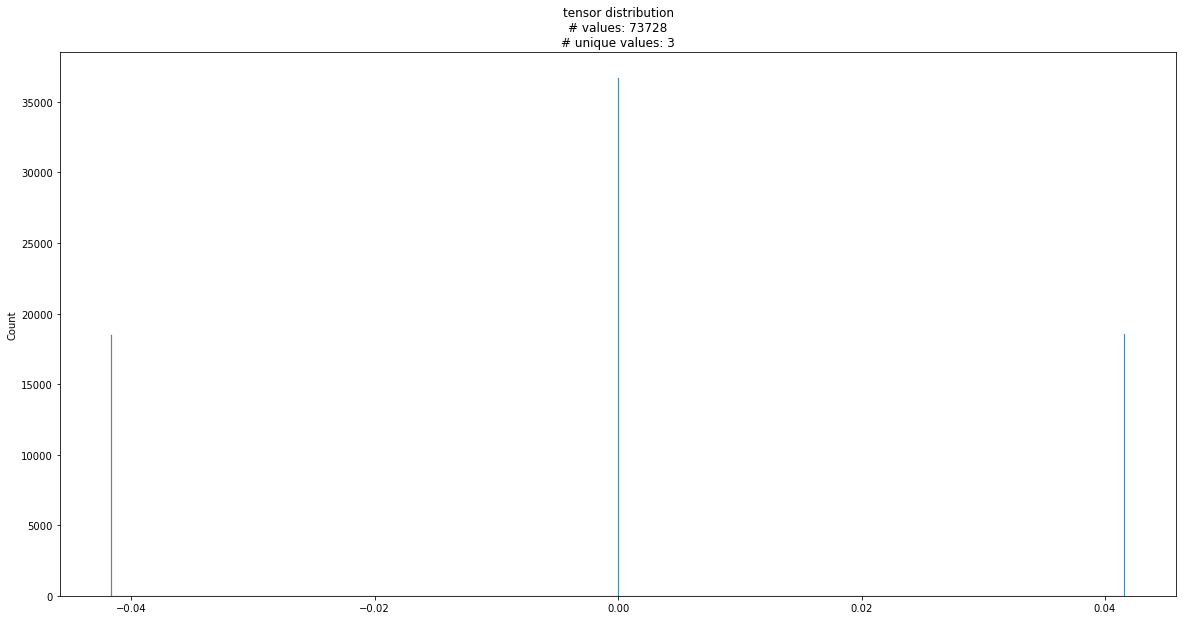

    bit-width: 3


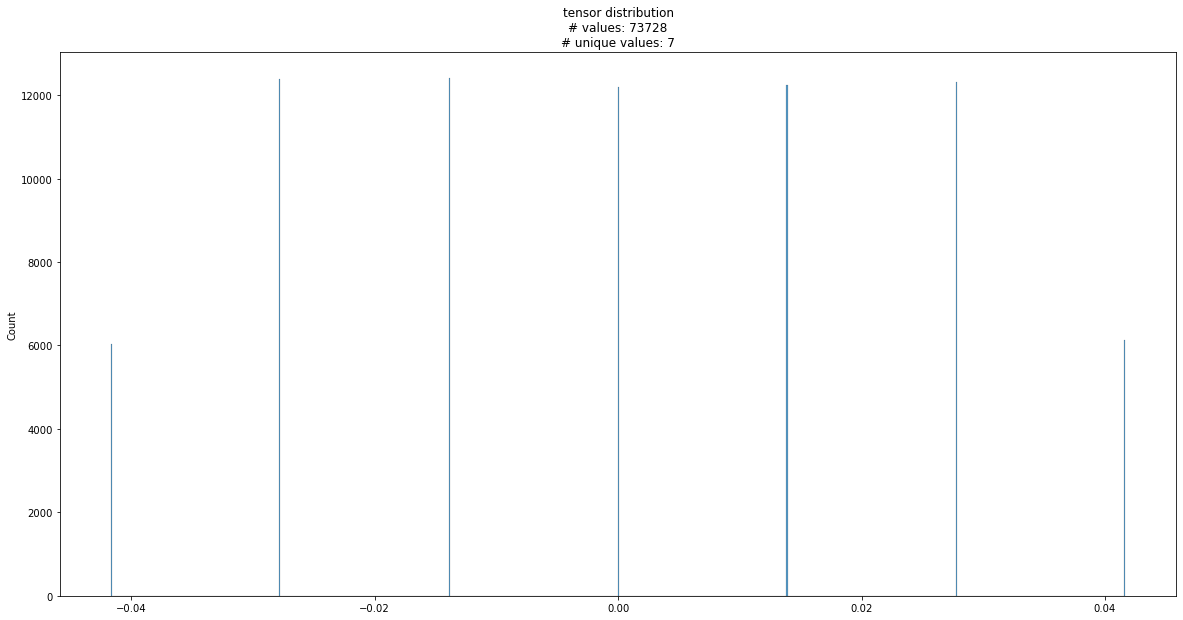

    bit-width: 4


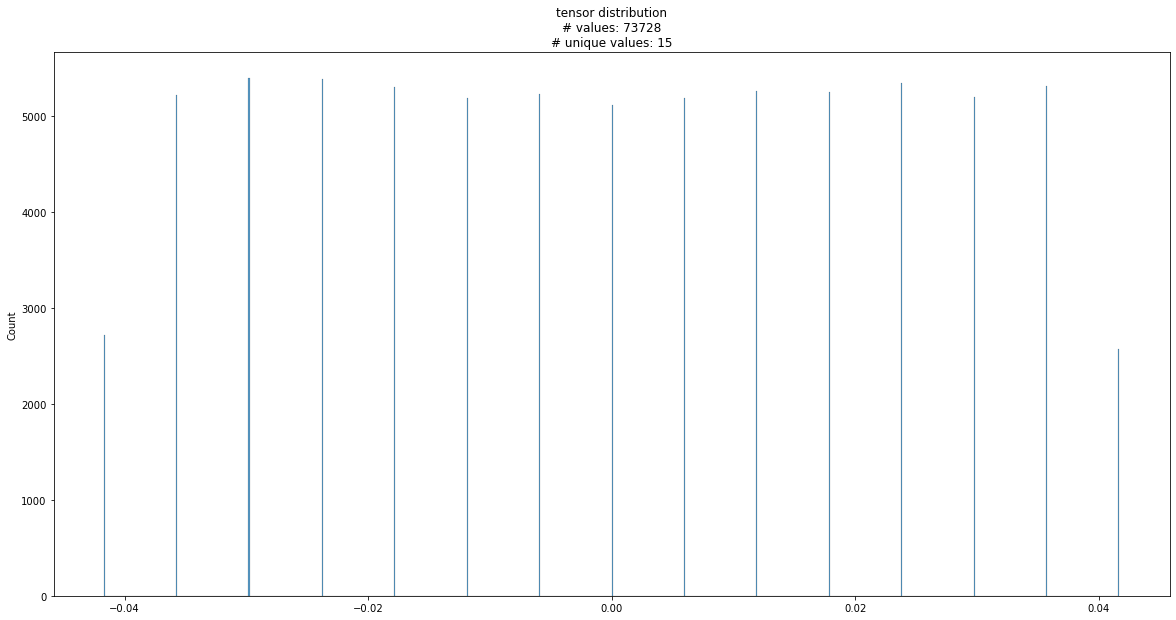

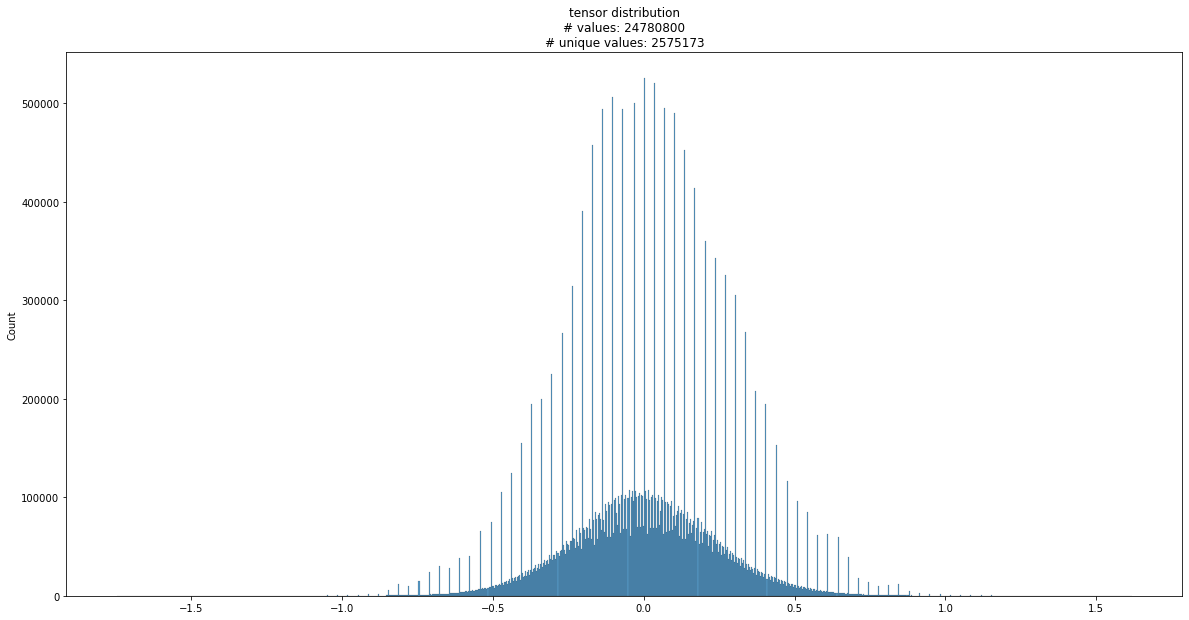

In [8]:
from architectures.Silhouette.components_Silhouette import SilhouetteConv2d

def test_SilhouetteConv2d(auxnet):
    print(f'**SilhouetteConv2d test**')
    
    policy = '2bit 50%, 3bit 30%, 4bit 20%'
    in_channels = 64
    out_channels = 128
    
    print(f'simiulate layer1.0.conv1: policy: {policy}, in_channels: {in_channels}, out_channels: {out_channels}, options: weight_scaling(X), interpolate before sectioning(X)')
    layer = SilhouetteConv2d(policy, in_channels, out_channels)
    assert layer.silhouette is None
    layer.silhouette = auxnet.silhouette
    assert layer.silhouette is not None
    
    print(f'mask generated:')
    masks = layer._generate_masks(feature_maps['before_layer1'].shape[-2:])
    visualize_tensor(integrate_mask(masks))
    visualize_tensor_distribution(masks, is_mask=True)
    print()
    
    print(f'quantized weights in conv layer:')
    for nbit, conv in layer.conv_layers.items():
        print(f'    bit-width: {nbit}')
        visualize_tensor_distribution(conv.quant_weight().value)
        
    y = layer(feature_maps['before_layer1'])
    visualize_tensor_distribution(y)
    
test_SilhouetteConv2d(auxnet)

**SilhouetteConv2d interpolate before vs after sectioning**
simiulate layer2.0.conv1: policy: 2bit 50%, 3bit 30%, 4bit 20%, in_channels: 128, out_channels: 256
mask interpolated before sectioning: 


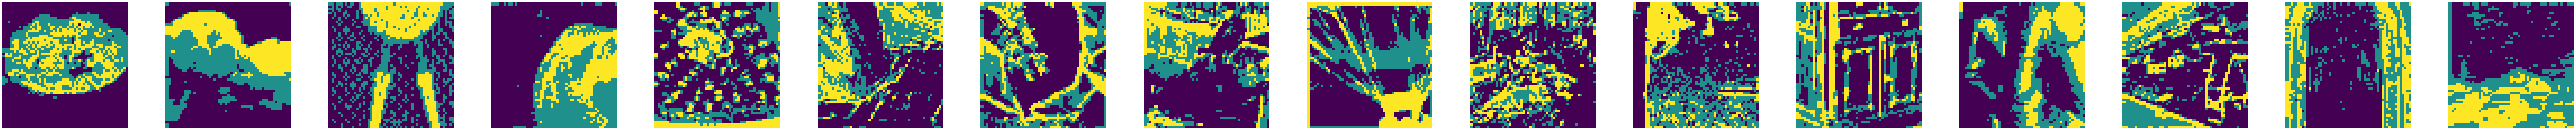

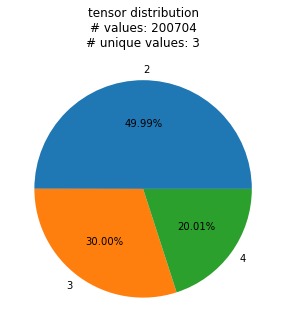

mask interpolated after sectioning: 


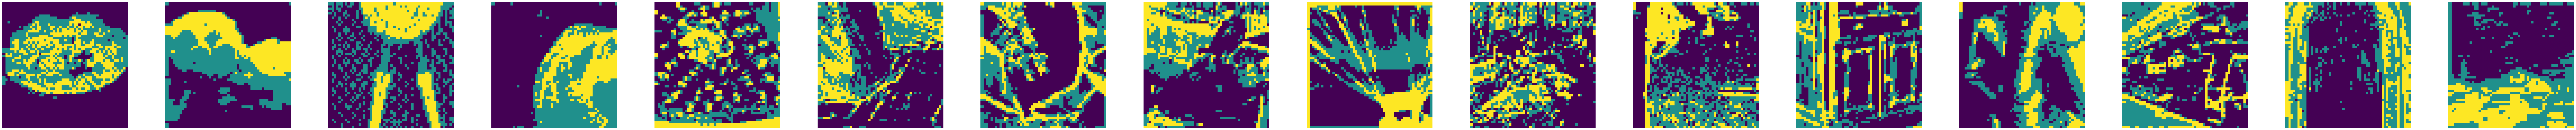

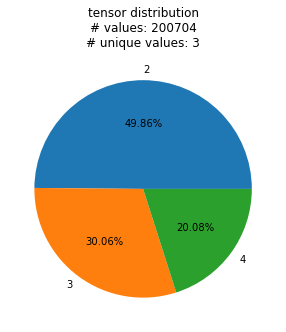

In [9]:
def test_SilhouetteConv2d_interpolate_before_vs_after_sectioning(auxnet):
    print(f'**SilhouetteConv2d interpolate before vs after sectioning**')
    
    policy = '2bit 50%, 3bit 30%, 4bit 20%'
    in_channels = 128
    out_channels = 256
    print(f'simiulate layer2.0.conv1: policy: {policy}, in_channels: {in_channels}, out_channels: {out_channels}')
    
    layer_before = SilhouetteConv2d(policy, in_channels, out_channels, interpolate_before_sectioning=True)
    layer_before.silhouette = auxnet.silhouette
    masks_before = layer_before._generate_masks(feature_maps['before_layer1'].shape[-2:])
    print(f'mask interpolated before sectioning: ')
    visualize_tensor(integrate_mask(masks_before))
    visualize_tensor_distribution(masks_before, is_mask=True)
    
    layer_after = SilhouetteConv2d(policy, in_channels, out_channels, interpolate_before_sectioning=False)
    layer_after.silhouette = auxnet.silhouette
    masks_after = layer_after._generate_masks(feature_maps['before_layer1'].shape[-2:])
    print(f'mask interpolated after sectioning: ')
    visualize_tensor(integrate_mask(masks_after))
    visualize_tensor_distribution(masks_after, is_mask=True)
    
test_SilhouetteConv2d_interpolate_before_vs_after_sectioning(auxnet)

## Models

### ResNet

In [10]:
from brevitas.nn import QuantConv2d
from architectures.common.components_common import *
from architectures.Silhouette.components_Silhouette import *
from architectures.Silhouette.models.resnet_Silhouette import resnet18_Silhouette

In [11]:
target_dataset = "ImageNet"
num_classes = 1000

model_config = {
    "backbone": "resnet18",
    "variation": "Silhouette",
    "config": {
        "aux_nets": {
            "A": {
                "extractor_config": {"in_channels": 64, "out_channels": num_classes},
                "compress_config": {"method": "topk_deviation_of_activation", "k": 5},
                "trigger": "layer1",
                "receivers": ["layer1"]
            },
            "B": {
                "extractor_config": {"in_channels": 64, "out_channels": num_classes},
                "compress_config": {"method": "max"},
                "trigger": "layer2",
                "receivers": ["layer2"]
            },
            "C": {
                "extractor_config": {"in_channels": 128, "out_channels": num_classes},
                "compress_config": {"method": "random"},
                "trigger": "layer3",
                "receivers": ["layer3"]
            }
        },
        "layers": {
            "layer1": {
                "sectioning_policy": "2bit 50%, 3bit 50%",
                "weight_scaling_per_output_channel": True,
                "interpolate_before_sectioning": True
            },
            "layer2": {
                "sectioning_policy": "2bit 80%, 3bit 20%",
                "weight_scaling_per_output_channel": True,
                "interpolate_before_sectioning": True
            },
            "layer3": {
                "sectioning_policy": "2bit 50%, 3bit 25%, 4bit 15%, 5bit 10%",
                "weight_scaling_per_output_channel": True,
                "interpolate_before_sectioning": True
            },
            "layer4": {
                "weight_bit_width": 4,
                "activation_bit_width": 4
            }
        }
    }
}
model = resnet18_Silhouette(target_dataset, model_config['config'])

#### Verify Silhouette model has well-made by configuration

In [12]:
def print_model(model):
    for name, m in model.named_modules():
        if type(m) == SilhouetteConv2d:
            print(f'{name}: SilhouetteConv2d({m.sectioning_policy})')
        elif type(m) == QuantConv2d and not 'conv_layers' in name:
            print(f'{name}: QuantConv2d({m.quant_weight().bit_width})')
        elif type(m) == QuantConv2d:
            print(f'    ㄴ{name}: QuantConv2d({m.quant_weight().bit_width})')
        elif type(m) == QuantPACTReLU:
            print(f'{name}: QuantPACTReLU({m.quant_act_bit_width().item()})')
        
            
print_model(model)

input_stem.2: QuantPACTReLU(8.0)
layer1.0.conv1: SilhouetteConv2d(2bit 50%, 3bit 50%)
    ㄴlayer1.0.conv1.conv_layers.2: QuantConv2d(2.0)
    ㄴlayer1.0.conv1.conv_layers.3: QuantConv2d(3.0)
layer1.0.relu1: QuantPACTReLU(2.0)
layer1.0.conv2: SilhouetteConv2d(2bit 50%, 3bit 50%)
    ㄴlayer1.0.conv2.conv_layers.2: QuantConv2d(2.0)
    ㄴlayer1.0.conv2.conv_layers.3: QuantConv2d(3.0)
layer1.0.relu2: QuantPACTReLU(2.0)
layer1.1.conv1: SilhouetteConv2d(2bit 50%, 3bit 50%)
    ㄴlayer1.1.conv1.conv_layers.2: QuantConv2d(2.0)
    ㄴlayer1.1.conv1.conv_layers.3: QuantConv2d(3.0)
layer1.1.relu1: QuantPACTReLU(2.0)
layer1.1.conv2: SilhouetteConv2d(2bit 50%, 3bit 50%)
    ㄴlayer1.1.conv2.conv_layers.2: QuantConv2d(2.0)
    ㄴlayer1.1.conv2.conv_layers.3: QuantConv2d(3.0)
layer1.1.relu2: QuantPACTReLU(2.0)
layer2.0.conv1: SilhouetteConv2d(2bit 80%, 3bit 20%)
    ㄴlayer2.0.conv1.conv_layers.2: QuantConv2d(2.0)
    ㄴlayer2.0.conv1.conv_layers.3: QuantConv2d(3.0)
layer2.0.relu1: QuantPACTReLU(2.0)
layer2.

#### Iterate new-made Silhouette model - no silhouette initialized for each layer

In [13]:
def iterate_Silhouette_model(model):
    for name, m in model.named_modules():
        if type(m) == SilhouetteConv2d:
            if m.silhouette is None:
                print(f'{name}: No stored silhouette')
            else:
                print(f'{name}: Stored silhouette size: {m.silhouette.size()}')
    
iterate_Silhouette_model(model)

layer1.0.conv1: No stored silhouette
layer1.0.conv2: No stored silhouette
layer1.1.conv1: No stored silhouette
layer1.1.conv2: No stored silhouette
layer2.0.conv1: No stored silhouette
layer2.0.conv2: No stored silhouette
layer2.0.shortcut.0: No stored silhouette
layer2.1.conv1: No stored silhouette
layer2.1.conv2: No stored silhouette
layer3.0.conv1: No stored silhouette
layer3.0.conv2: No stored silhouette
layer3.0.shortcut.0: No stored silhouette
layer3.1.conv1: No stored silhouette
layer3.1.conv2: No stored silhouette


#### forward Silhouette model and check activate order between layers and aux_nets

In [14]:
def forward_Silhouette_model_and_check_activate_order(model, config):
    def activate_alert(modulename):
        def hook(M, I, O):
            print(f'{modulename} activated!')
        return hook
    
    handlers = []
            
    for name, auxnet in model.aux_nets.items():
        handlers.append(auxnet.register_forward_hook(activate_alert(name)))
        triggername = config['aux_nets'][name]['trigger']
        handlers.append(getattr(model, triggername).register_forward_hook(activate_alert(triggername)))
        
    model(sample['batch']['images'])
    
    for handler in handlers:
        handler.remove()
        
forward_Silhouette_model_and_check_activate_order(model, model_config['config'])

A activated!
layer1 activated!
B activated!
layer2 activated!
C activated!
layer3 activated!


#### Iterate Silhouette model that forwarded - silhouettes stored in each layer

In [15]:
iterate_Silhouette_model(model)

layer1.0.conv1: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer1.0.conv2: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer1.1.conv1: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer1.1.conv2: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer2.0.conv1: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer2.0.conv2: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer2.0.shortcut.0: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer2.1.conv1: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer2.1.conv2: Stored silhouette size: torch.Size([16, 1, 27, 27])
layer3.0.conv1: Stored silhouette size: torch.Size([16, 1, 13, 13])
layer3.0.conv2: Stored silhouette size: torch.Size([16, 1, 13, 13])
layer3.0.shortcut.0: Stored silhouette size: torch.Size([16, 1, 13, 13])
layer3.1.conv1: Stored silhouette size: torch.Size([16, 1, 13, 13])
layer3.1.conv2: Stored silhouette size: torch.Size([16, 1, 13, 13])


#### check layer-wise stored silhouettes and generated masks(based on passed silhouette)

layer1.0.conv1
silhouette(compressed attention map)


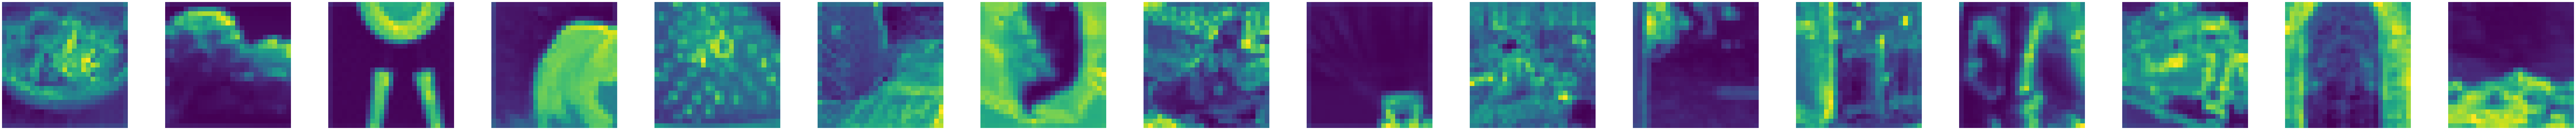

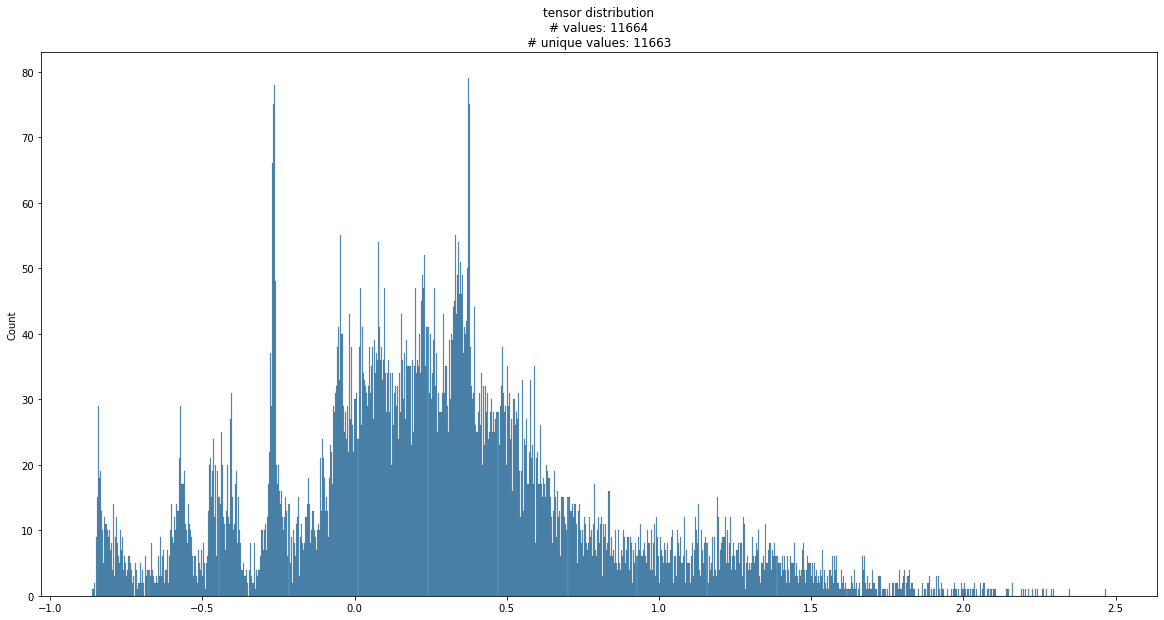

masks


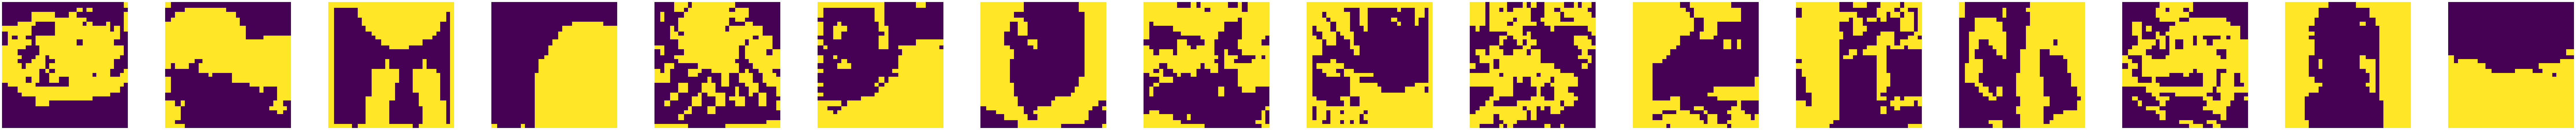

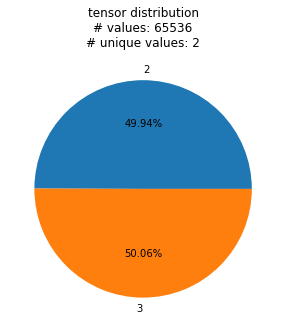


layer2.0.conv1
silhouette(compressed attention map)


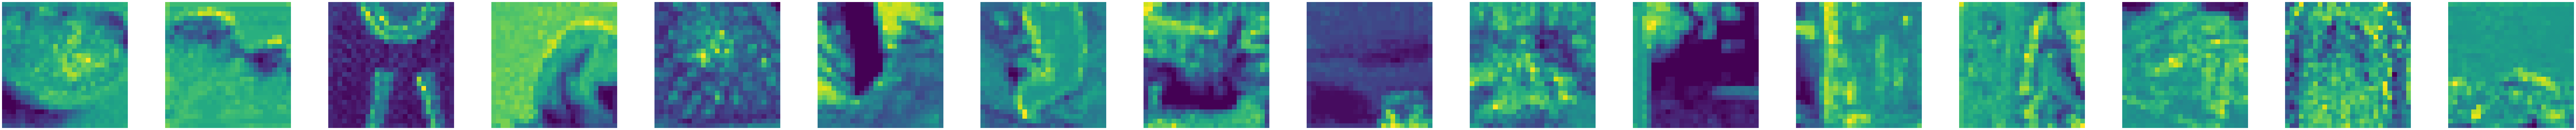

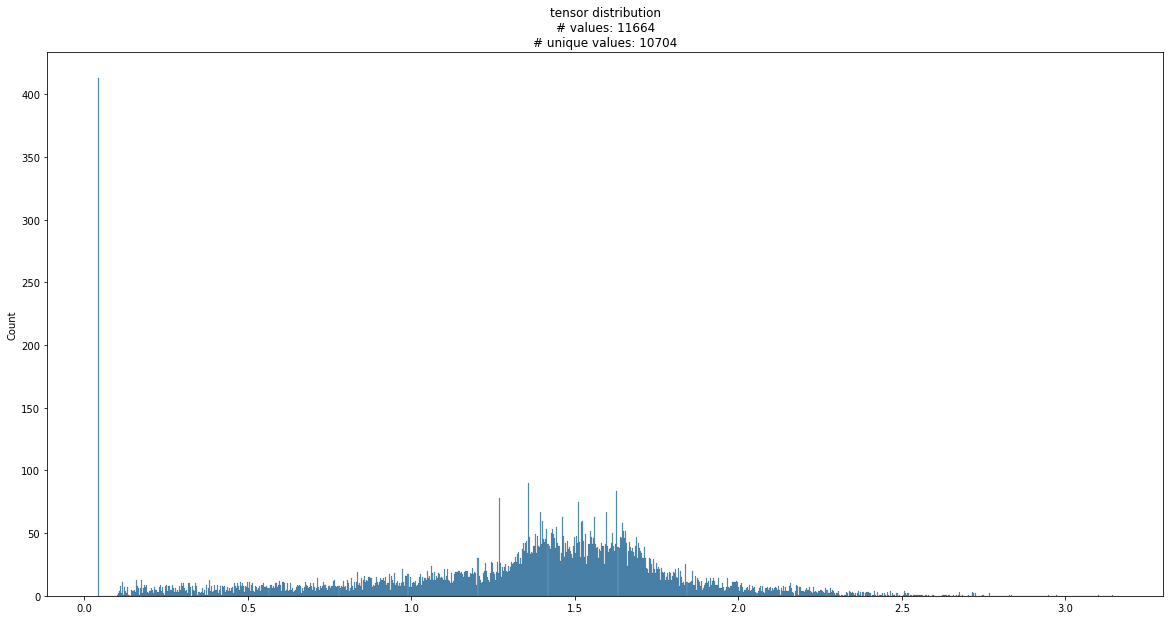

masks


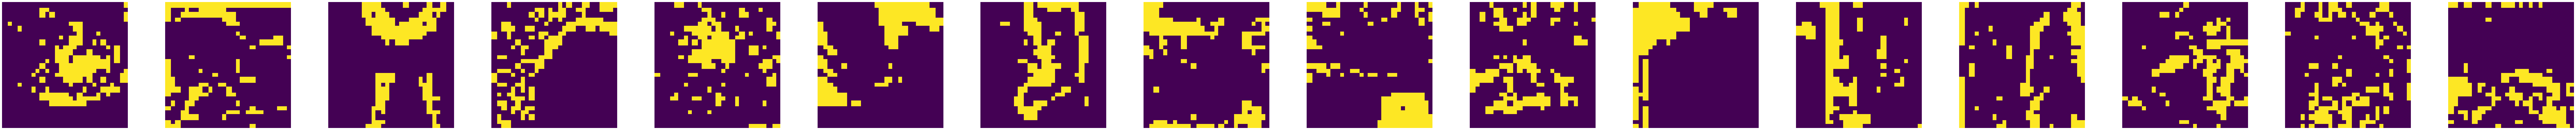

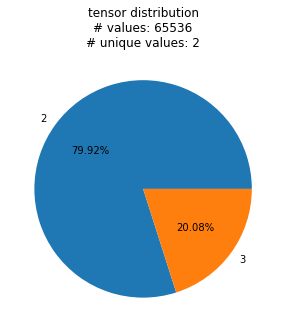


layer3.0.conv1
silhouette(compressed attention map)


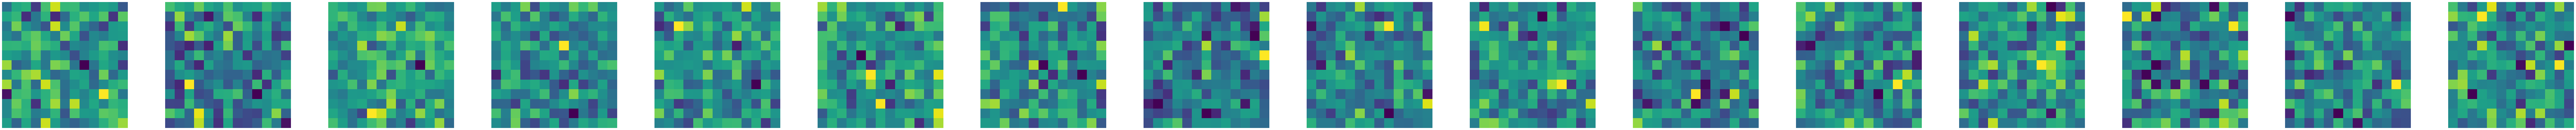

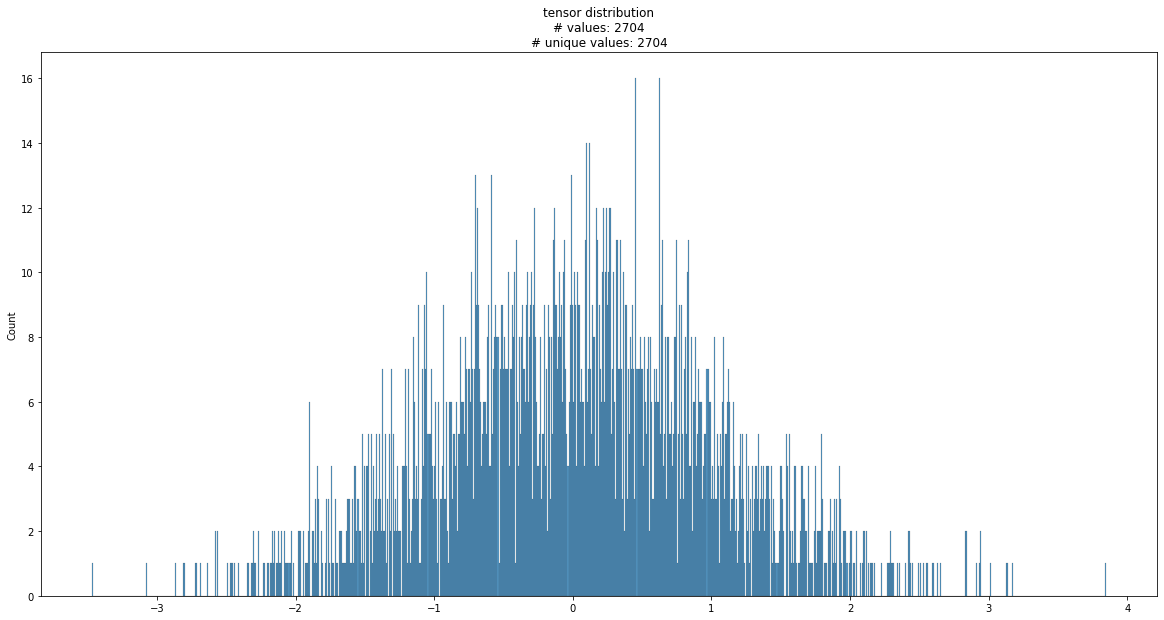

masks


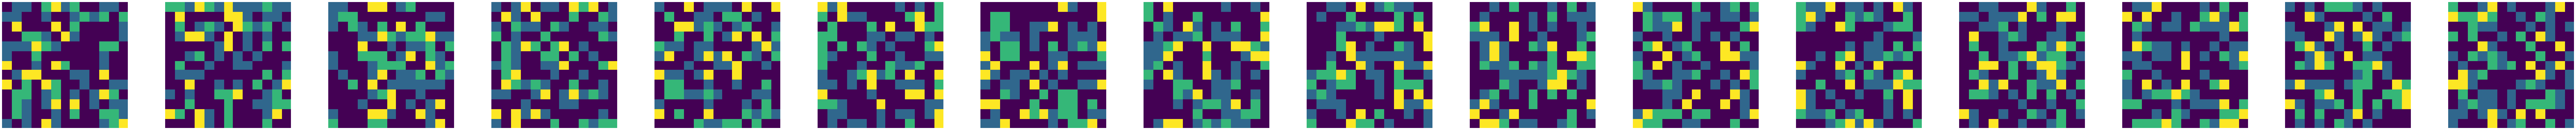

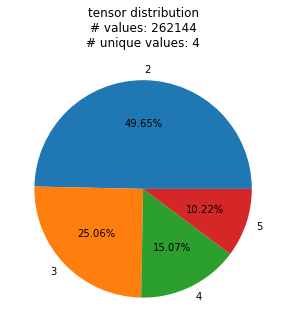

In [16]:
# due to a lot of pictures, we will see only some of layers.
def check_layerwise_stored_silhouettes_and_generated_masks(model, config):
    print(f'layer1.0.conv1')
    print('silhouette(compressed attention map)')
    visualize_tensor(model.layer1[0].conv1.silhouette)
    visualize_tensor_distribution(model.layer1[0].conv1.silhouette)
    print('masks')
    visualize_tensor(integrate_mask(model.layer1[0].conv1._generate_masks((64, 64))))
    visualize_tensor_distribution(model.layer1[0].conv1._generate_masks((64, 64)), is_mask=True)
    print()
    
    print(f'layer2.0.conv1')
    print('silhouette(compressed attention map)')
    visualize_tensor(model.layer2[0].conv1.silhouette)
    visualize_tensor_distribution(model.layer2[0].conv1.silhouette)
    print('masks')
    visualize_tensor(integrate_mask(model.layer2[0].conv1._generate_masks((64, 64))))
    visualize_tensor_distribution(model.layer2[0].conv1._generate_masks((64, 64)), is_mask=True)
    print()
    
    print(f'layer3.0.conv1')
    print('silhouette(compressed attention map)')
    visualize_tensor(model.layer3[0].conv1.silhouette)
    visualize_tensor_distribution(model.layer3[0].conv1.silhouette)
    print('masks')
    visualize_tensor(integrate_mask(model.layer3[0].conv1._generate_masks((128, 128))))
    visualize_tensor_distribution(model.layer3[0].conv1._generate_masks((128, 128)), is_mask=True)
    print()
    
check_layerwise_stored_silhouettes_and_generated_masks(model, model_config['config'])